В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

**Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто заадча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

Area under ROC score on Train dataset: 0.77


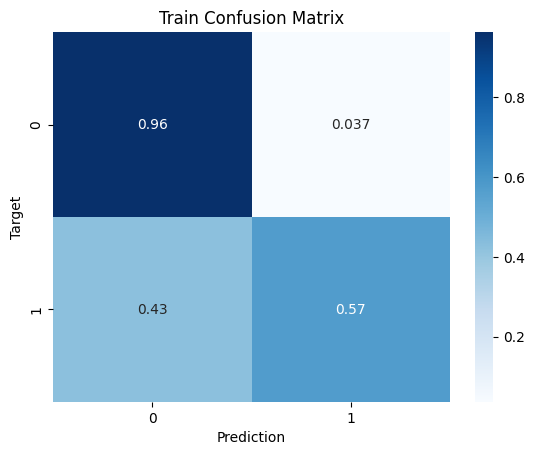

Area under ROC score on Validation dataset: 0.76


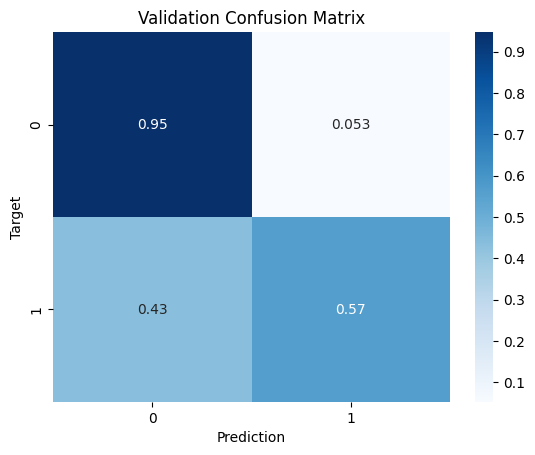

['model_pipeline.joblib']

In [15]:
# Завантаження даних
raw_df = pd.read_csv('/content/drive/MyDrive/Data Science/train.csv', index_col=0)

# Розділення даних на тренувальні та валідаційні набори
train_df, val_df = train_test_split(raw_df, test_size=0.2, random_state=42, stratify=raw_df['Exited'])

# Створення тренувальних і валідаційних наборів
input_cols = list(train_df.columns)[1:-1]
target_col = 'Exited'
train_inputs, train_targets = train_df[input_cols], train_df[target_col]
val_inputs, val_targets = val_df[input_cols], val_df[target_col]

# Виявлення числових і категоріальних колонок
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes(include='object').columns.tolist()

# Створення трансформерів для числових і категоріальних колонок
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Комбінування трансформерів для різних типів колонок в один препроцесор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Створення пайплайну, який спочатку запускає препроцесинг, потім тренує модель
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Тренування пайплайну
model_pipeline.fit(train_inputs, train_targets)

# Функція для передбачення та обчислення метрик
def predict_and_plot(model_pipeline, inputs, targets, name=''):
    preds = model_pipeline.predict(inputs)
    fpr, tpr, _ = roc_curve(targets, preds)
    roc_auc = auc(fpr, tpr)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.2f}")
    confusion_matrix_ = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(confusion_matrix_, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds

# Оцінка моделі на тренувальних та валідаційних даних
train_preds = predict_and_plot(model_pipeline, train_inputs, train_targets, 'Train')
val_preds = predict_and_plot(model_pipeline, val_inputs, val_targets, 'Validation')

# Збереження моделі для подальшого використання
joblib.dump(model_pipeline, 'model_pipeline.joblib')



**Завдання 2**. Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?

Area under ROC score on Train dataset: 0.79


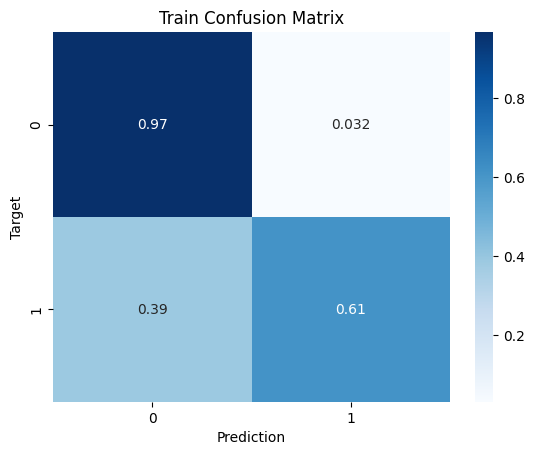

Area under ROC score on Validation dataset: 0.78


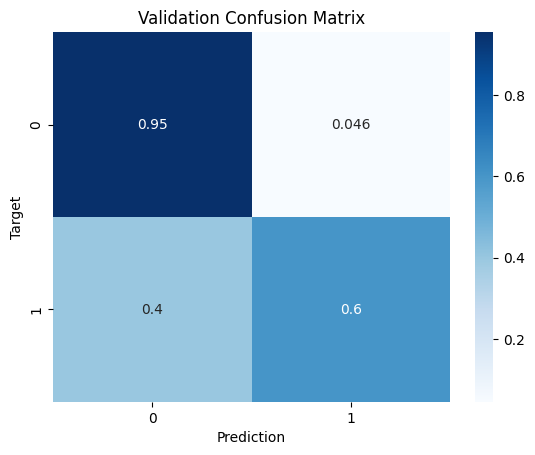

['model_pipeline_with_poly.joblib']

In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, confusion_matrix
import operator
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns
import matplotlib.pyplot as plt
import joblib


# Завантаження даних
raw_df = pd.read_csv('/content/drive/MyDrive/Data Science/train.csv', index_col=0)

# Розділення даних на тренувальні та валідаційні набори
train_df, val_df = train_test_split(raw_df, test_size=0.2, random_state=42, stratify=raw_df['Exited'])

# Створення тренувальних і валідаційних наборів
input_cols = list(train_df.columns)[1:-1]
target_col = 'Exited'
train_inputs, train_targets = train_df[input_cols], train_df[target_col]
val_inputs, val_targets = val_df[input_cols], val_df[target_col]

# Виявлення числових і категоріальних колонок
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes(include='object').columns.tolist()

# Створення трансформерів для числових і категоріальних колонок з поліноміальними ознаками
numeric_transformer = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Комбінування трансформерів для різних типів колонок в один препроцесор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Створення пайплайну, який спочатку запускає препроцесинг, потім тренує модель
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Тренування пайплайну
model_pipeline.fit(train_inputs, train_targets)

# Функція для передбачення та обчислення метрик
def predict_and_plot(model_pipeline, inputs, targets, name=''):
    preds = model_pipeline.predict(inputs)
    fpr, tpr, _ = roc_curve(targets, preds)
    roc_auc = auc(fpr, tpr)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.2f}")
    confusion_matrix_ = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(confusion_matrix_, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds

# Оцінка моделі на тренувальних та валідаційних даних
train_preds = predict_and_plot(model_pipeline, train_inputs, train_targets, 'Train')
val_preds = predict_and_plot(model_pipeline, val_inputs, val_targets, 'Validation')

# Збереження моделі для подальшого використання
joblib.dump(model_pipeline, 'model_pipeline_with_poly.joblib')


**Висновок**: метрики на тренувальному і валідаційному наборах близькі та високі, це свідчить про добру генералізацію моделі.

**Завдання 3**. Тепер давайте створимо ще новий пайплайн, тільки тепер поліноміальні ознаки згенеруємо до степені 4. Зробіть висновок про якість моделі. Якщо вам подобається резульат якоїсь з моделей в цьому ДЗ - рекомендую зробити submission в змаганні.

Area under ROC score on Train dataset: 0.83


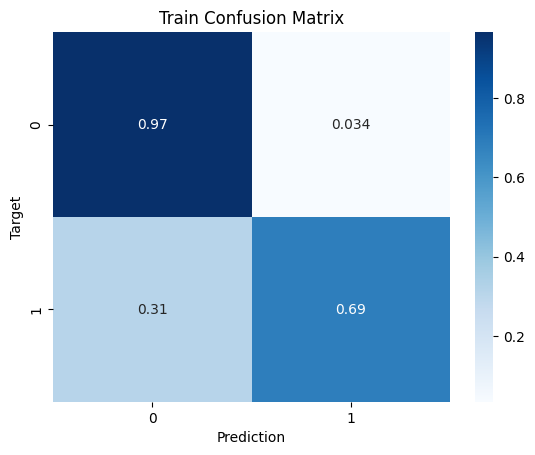

Area under ROC score on Validation dataset: 0.81


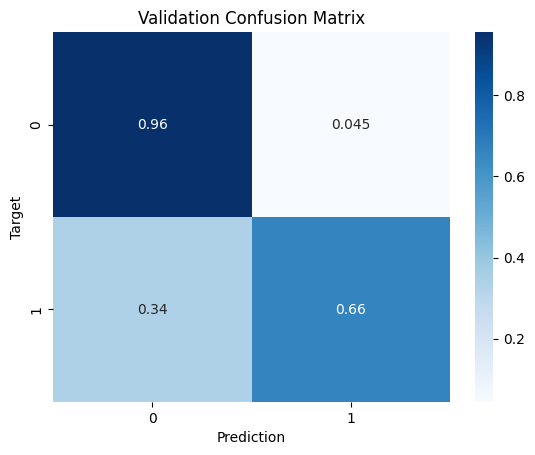

['model_pipeline_with_poly.joblib']

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, confusion_matrix
import operator
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns
import matplotlib.pyplot as plt
import joblib


# Завантаження даних
raw_df = pd.read_csv('/content/drive/MyDrive/Data Science/train.csv', index_col=0)

# Розділення даних на тренувальні та валідаційні набори
train_df, val_df = train_test_split(raw_df, test_size=0.2, random_state=42, stratify=raw_df['Exited'])

# Створення тренувальних і валідаційних наборів
input_cols = list(train_df.columns)[1:-1]
target_col = 'Exited'
train_inputs, train_targets = train_df[input_cols], train_df[target_col]
val_inputs, val_targets = val_df[input_cols], val_df[target_col]

# Виявлення числових і категоріальних колонок
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes(include='object').columns.tolist()

# Створення трансформерів для числових і категоріальних колонок з поліноміальними ознаками
numeric_transformer = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=4, include_bias=False)),
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Комбінування трансформерів для різних типів колонок в один препроцесор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Створення пайплайну, який спочатку запускає препроцесинг, потім тренує модель
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Тренування пайплайну
model_pipeline.fit(train_inputs, train_targets)

# Функція для передбачення та обчислення метрик
def predict_and_plot(model_pipeline, inputs, targets, name=''):
    preds = model_pipeline.predict(inputs)
    fpr, tpr, _ = roc_curve(targets, preds)
    roc_auc = auc(fpr, tpr)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.2f}")
    confusion_matrix_ = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(confusion_matrix_, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds

# Оцінка моделі на тренувальних та валідаційних даних
train_preds = predict_and_plot(model_pipeline, train_inputs, train_targets, 'Train')
val_preds = predict_and_plot(model_pipeline, val_inputs, val_targets, 'Validation')

# Збереження моделі для подальшого використання
joblib.dump(model_pipeline, 'model_pipeline_with_poly.joblib')


Висновок: Ця модель має трохи кращі метрики в порівнянні з попередньою.

**Завдання 4. Перенавчання і регуляризація**.

  Скачайте набір даних `regression_data.csv`. Звичайте набір даних з `regression_data.csv`, розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?


In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


data=pd.read_csv('/content/drive/MyDrive/Data Science/regression_data.csv')

# Визначення вхідних та цільових колонок
input_cols = data.columns[:-1]
target_col = data.columns[-1]

# Розділення даних на тренувальний і тестовий набори
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

train_inputs, train_targets = train_data[input_cols], train_data[target_col]
test_inputs, test_targets = test_data[input_cols], test_data[target_col]

# Виявлення числових колонок
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()

# Створення трансформеру для числових колонок з поліноміальними ознаками до степені 5
numeric_transformer = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=5, include_bias=False)),
    ('scaler', MinMaxScaler())
])

# Комбінування трансформерів для числових колонок в один препроцесор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols)
    ])

# Створення пайплайну, який спочатку запускає препроцесинг, потім тренує модель
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Тренування пайплайну
model_pipeline.fit(train_inputs, train_targets)

# Передбачення на тренувальних та тестових даних
train_preds = model_pipeline.predict(train_inputs)
test_preds = model_pipeline.predict(test_inputs)

# Оцінка моделі на тренувальному та тестовому наборі
train_rmse = np.sqrt(mean_squared_error(train_targets, train_preds))
test_rmse = np.sqrt(mean_squared_error(test_targets, test_preds))
train_r2 = r2_score(train_targets, train_preds)
test_r2 = r2_score(test_targets, test_preds)

print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')
print(f'Train R^2: {train_r2:.2f}')
print(f'Test R^2: {test_r2:.2f}')



Train RMSE: 0.00
Test RMSE: 12.90
Train R^2: 1.00
Test R^2: 0.93


**Висновок:**

*Train RMSE*: 0.00 та Train R^2: 1.00:
Модель ідеально підходить для тренувальних даних. Значення RMSE дорівнює нулю, а R^2 дорівнює 1, означає, що модель на 100% пояснює варіативність тренувальних даних.
  
*Test RMSE*: 12.90 та Test R^2: 0.93:
Значення RMSE на тестових даних становить 12.90, що значно більше, ніж на тренувальних даних. Це вказує на те, що модель має більшу помилку при прогнозуванні нових даних.
Значення R^2 на тестових даних становить 0.93, що вказує на те, що модель добре пояснює варіативність даних (93%), але не так добре, як на тренувальних даних.
**Висновок**- overfitting:
Модель дуже добре підходить до тренувальних даних (RMSE = 0.00, R^2 = 1.00), але має вищу помилку на тестових даних (RMSE = 12.90), хоча і з високим значенням R^2 (0.93).

**Завдання 5**. Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лінійною регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?

In [43]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error

# Завантаження даних
data = pd.read_csv('/content/drive/MyDrive/Data Science/regression_data.csv')  # замініть шлях до файлу на відповідний

# Визначення вхідних та цільових колонок
input_cols = data.columns[:-1]
target_col = data.columns[-1]

# Розділення даних на тренувальний і тестовий набори
X_train, X_val, y_train, y_val = train_test_split(data[input_cols], data[target_col], test_size=0.2, random_state=42)

# Генерація поліноміальних ознак до степені 20
poly_features = PolynomialFeatures(degree=20, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)
X_val_poly = poly_features.transform(X_val)

# Масштабування ознак
scaler = MinMaxScaler()
X_train_poly = scaler.fit_transform(X_train_poly)
X_val_poly = scaler.transform(X_val_poly)

# Ігнорування попереджень
import warnings
warnings.filterwarnings("ignore")

# Моделі
models = [
    LinearRegression(),
    Ridge(),
    Ridge(alpha=2),
    Lasso(),
    ElasticNet(),
    ElasticNet(alpha=0.5)
]

# Оцінки моделі
def evaluate_model(model, X_train, y_train, X_val, y_val):
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    train_metrics = mean_squared_error(y_train, y_train_pred, squared=False).round(6)
    val_metrics = mean_squared_error(y_val, y_val_pred, squared=False).round(6)

    return dict(train=train_metrics, val=val_metrics)

# Тренування і оцінка моделей
for model in models:
    model.fit(X_train_poly, y_train)
    eval_results  = evaluate_model(model, X_train_poly, y_train, X_val_poly, y_val)
    print(f'{str(model)}: {eval_results}\n')


LinearRegression(): {'train': 0.0, 'val': 49.561467}

Ridge(): {'train': 8.59775, 'val': 76.562708}

Ridge(alpha=2): {'train': 12.406284, 'val': 94.079153}

Lasso(): {'train': 5.098171, 'val': 5.671931}

ElasticNet(): {'train': 34.179765, 'val': 116.029707}

ElasticNet(alpha=0.5): {'train': 29.38021, 'val': 154.530517}



**Висновок:**

1) LinearRegression:

Train RMSE: 0.0
Val RMSE: 49.561467.
 Модель перенавчена (overfitted), оскільки вона має ідеальне прогнозування на тренувальних даних (RMSE = 0.0), але значно гірше на валідаційних даних.

2)Ridge:

Train RMSE: 8.59775
Val RMSE: 76.562708.
 Модель має менш виражене перенавчання порівняно з лінійною регресією, але все ще не дуже добре узагальнює.

3)Ridge(alpha=2):

Train RMSE: 12.406284
Val RMSE: 94.079153.
Збільшення параметра регуляризації знижує перенавчання, але також підвищує помилку на валідаційних даних.

4)Lasso:

Train RMSE: 5.098171
Val RMSE: 5.671931.
 Lasso регресія показала найкращі результати серед усіх моделей, оскільки її значення RMSE для тренувальних і валідаційних даних найближчі.

5)ElasticNet:

Train RMSE: 34.179765
Val RMSE: 116.029707.
 Модель має дуже високі значення RMSE як на тренувальних, так і на валідаційних даних, що вказує на її неспроможність добре узагальнювати дані.

6)ElasticNet(alpha=0.5):

Train RMSE: 29.38021
Val RMSE: 154.530517.
Зміна параметра регуляризації лише погіршила результати, що вказує на недонвчання моделі.